# NB04 — In-Silico KO Comparison: HepG2 vs Jurkat

**Analysis date:** 2026-02-27

## Question
When the model is causally deprived of a specific input gene's expression (in-silico KO),
does the predicted output change in a pathway-coherent way, and does this differ across
cell lines in a biologically meaningful way?

This is a harder causal intervention than the Jacobian: instead of measuring local sensitivity
(∂Y/∂X), we set X_i = 0 and measure the resulting global shift in predicted output.

**Cross-cell-line correlation (4b) directly parallels NB08 zeroshot/fewshot:**
- High r → backbone-level regulatory routing (should match high zeroshot r genes)
- Low r → cell-line-specific (fine-tune artifact; should match low zeroshot r genes like TRAPPC3)


## Setup — Imports and Data Loading

In [1]:

import numpy as np
import pickle
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Paths
WORK_DIR = '/mnt/polished-lake/home/mbeheleramass'
OUT_DIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
VAR_DIMS_PATH = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
                 'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl')

# Load data
ko_h     = np.load(f'{WORK_DIR}/insilico_ko_hepg2.npy')
ko_j     = np.load(f'{WORK_DIR}/insilico_ko_jurkat.npy')
gene_idx = np.load(f'{WORK_DIR}/insilico_ko_gene_idx.npy')

var_dims   = pickle.load(open(VAR_DIMS_PATH, 'rb'))
gene_names = var_dims['gene_names']   # 2000-element list

ko_gene_names = [gene_names[i] for i in gene_idx]

print(f"ko_h  shape : {ko_h.shape}")
print(f"ko_j  shape : {ko_j.shape}")
print(f"gene_idx shape : {gene_idx.shape}")
print(f"gene_idx range : [{gene_idx.min()}, {gene_idx.max()}]")
print(f"\nNumber of output gene names: {len(gene_names)}")
print(f"\nFirst 10 KO'd genes: {ko_gene_names[:10]}")


ModuleNotFoundError: No module named 'numpy'

In [2]:

import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.11/site-packages')
print(sys.version)
import numpy as np
print("numpy OK:", np.__version__)


3.13.12 (main, Feb 12 2026, 00:45:41) [Clang 21.1.4 ]


ModuleNotFoundError: No module named 'numpy'

In [3]:

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c',
     'import numpy; print(numpy.__version__); import sys; print(sys.version)'],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr)


2.2.6
3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]




In [4]:

import subprocess, sys, os

CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'

# Sanity check: confirm key packages available
check = subprocess.run(
    [CONDA_PY, '-c',
     'import numpy, scipy, sklearn, umap, matplotlib; '
     'print("numpy", numpy.__version__); '
     'print("scipy", scipy.__version__); '
     'print("sklearn", sklearn.__version__); '
     'print("umap", umap.__version__); '
     'print("matplotlib", matplotlib.__version__)'],
    capture_output=True, text=True
)
print(check.stdout)
if check.stderr:
    print("STDERR:", check.stderr[:500])


numpy 2.2.6
scipy 1.15.3
sklearn 1.7.2
umap 0.5.11
matplotlib 3.10.8



## 4a — Sanity Check: Data Shapes and KO Effect Magnitudes

In [5]:

CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'

script_4a = r"""
import numpy as np, pickle, matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

WORK_DIR = '/mnt/polished-lake/home/mbeheleramass'
OUT_DIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
VAR_DIMS = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
            'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl')

ko_h     = np.load(f'{WORK_DIR}/insilico_ko_hepg2.npy')
ko_j     = np.load(f'{WORK_DIR}/insilico_ko_jurkat.npy')
gene_idx = np.load(f'{WORK_DIR}/insilico_ko_gene_idx.npy')

var_dims   = pickle.load(open(VAR_DIMS, 'rb'))
gene_names = var_dims['gene_names']
ko_gene_names = [gene_names[i] for i in gene_idx]

print(f"ko_h  shape : {ko_h.shape}  dtype={ko_h.dtype}")
print(f"ko_j  shape : {ko_j.shape}  dtype={ko_j.dtype}")
print(f"gene_idx    : {gene_idx.shape}  range=[{gene_idx.min()}, {gene_idx.max()}]")
print(f"gene_names  : {len(gene_names)} total HVGs")
print(f"\nFirst 15 KO genes: {ko_gene_names[:15]}")

# Per-gene effect magnitude: L2 norm of KO response vector
mag_h = np.linalg.norm(ko_h, axis=1)
mag_j = np.linalg.norm(ko_j, axis=1)

print(f"\nHepG2 KO magnitude — mean={mag_h.mean():.4f}  std={mag_h.std():.4f}  "
      f"min={mag_h.min():.4f}  max={mag_h.max():.4f}")
print(f"Jurkat KO magnitude — mean={mag_j.mean():.4f}  std={mag_j.std():.4f}  "
      f"min={mag_j.min():.4f}  max={mag_j.max():.4f}")

# Top-5 / bottom-5 by HepG2 magnitude
order = np.argsort(mag_h)
print("\n--- 5 genes with LOWEST KO effect (HepG2) ---")
for i in order[:5]:
    print(f"  {ko_gene_names[i]:15s}  mag_h={mag_h[i]:.4f}  mag_j={mag_j[i]:.4f}")
print("\n--- 5 genes with HIGHEST KO effect (HepG2) ---")
for i in order[-5:][::-1]:
    print(f"  {ko_gene_names[i]:15s}  mag_h={mag_h[i]:.4f}  mag_j={mag_j[i]:.4f}")

# ---- Figure: KO effect magnitude histogram ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(mag_h, bins=30, color='steelblue', alpha=0.7, edgecolor='white', label='HepG2')
axes[0].hist(mag_j, bins=30, color='tomato',    alpha=0.7, edgecolor='white', label='Jurkat')
axes[0].axvline(mag_h.mean(), color='steelblue', ls='--', lw=1.5, label=f'HepG2 mean={mag_h.mean():.3f}')
axes[0].axvline(mag_j.mean(), color='tomato',    ls='--', lw=1.5, label=f'Jurkat mean={mag_j.mean():.3f}')
axes[0].set_xlabel('L2 norm of KO response vector', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('KO Effect Magnitude Distribution', fontsize=13)
axes[0].legend(fontsize=10)

# Scatter: HepG2 vs Jurkat magnitude
axes[1].scatter(mag_h, mag_j, c='slategray', alpha=0.6, s=30, edgecolors='none')
# Label top 10 by HepG2 magnitude
for i in order[-10:]:
    axes[1].annotate(ko_gene_names[i], (mag_h[i], mag_j[i]),
                     fontsize=7, ha='left', va='bottom',
                     xytext=(2,2), textcoords='offset points')
lim_max = max(mag_h.max(), mag_j.max()) * 1.05
axes[1].plot([0, lim_max], [0, lim_max], 'k--', lw=1, alpha=0.4, label='y=x')
axes[1].set_xlabel('HepG2 KO magnitude', fontsize=12)
axes[1].set_ylabel('Jurkat KO magnitude', fontsize=12)
axes[1].set_title('KO Effect: HepG2 vs Jurkat', fontsize=13)
axes[1].legend(fontsize=9)

plt.tight_layout()
fig.savefig(f'{OUT_DIR}/nb04_ko_effect_magnitude.png', dpi=150, bbox_inches='tight')
plt.close()
print("\nSaved: nb04_ko_effect_magnitude.png")
"""

import subprocess
result = subprocess.run([CONDA_PY, '-c', script_4a], capture_output=True, text=True,
                       cwd='/mnt/polished-lake/home/mbeheleramass')
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])


ko_h  shape : (200, 2000)  dtype=float32
ko_j  shape : (200, 2000)  dtype=float32
gene_idx    : (200,)  range=[41, 1990]
gene_names  : 2000 total HVGs

First 15 KO genes: ['RBAK', 'PLXNA1', 'ZNF92', 'BLZF1', 'SHQ1', 'SOS2', 'LRCH4', 'ELP1', 'ZBTB37', 'FBXW7', 'CCSAP', 'HCFC1R1', 'SWAP70', 'ANKRD36C', 'SPPL2B']

HepG2 KO magnitude — mean=0.2340  std=0.0784  min=0.0758  max=0.8371
Jurkat KO magnitude — mean=0.3306  std=0.0531  min=0.1493  max=0.5009

--- 5 genes with LOWEST KO effect (HepG2) ---
  TMEM131L         mag_h=0.0758  mag_j=0.3592
  SP100            mag_h=0.0801  mag_j=0.3539
  DNAH14           mag_h=0.0955  mag_j=0.2784
  PTBP2            mag_h=0.1167  mag_j=0.2836
  ZNF280D          mag_h=0.1257  mag_j=0.4056

--- 5 genes with HIGHEST KO effect (HepG2) ---
  ASPSCR1          mag_h=0.8371  mag_j=0.2650
  IER3             mag_h=0.5413  mag_j=0.2432
  SAT1             mag_h=0.5069  mag_j=0.3061
  PCGF5            mag_h=0.4220  mag_j=0.3808
  TRIM24           mag_h=0.4163  mag_j=

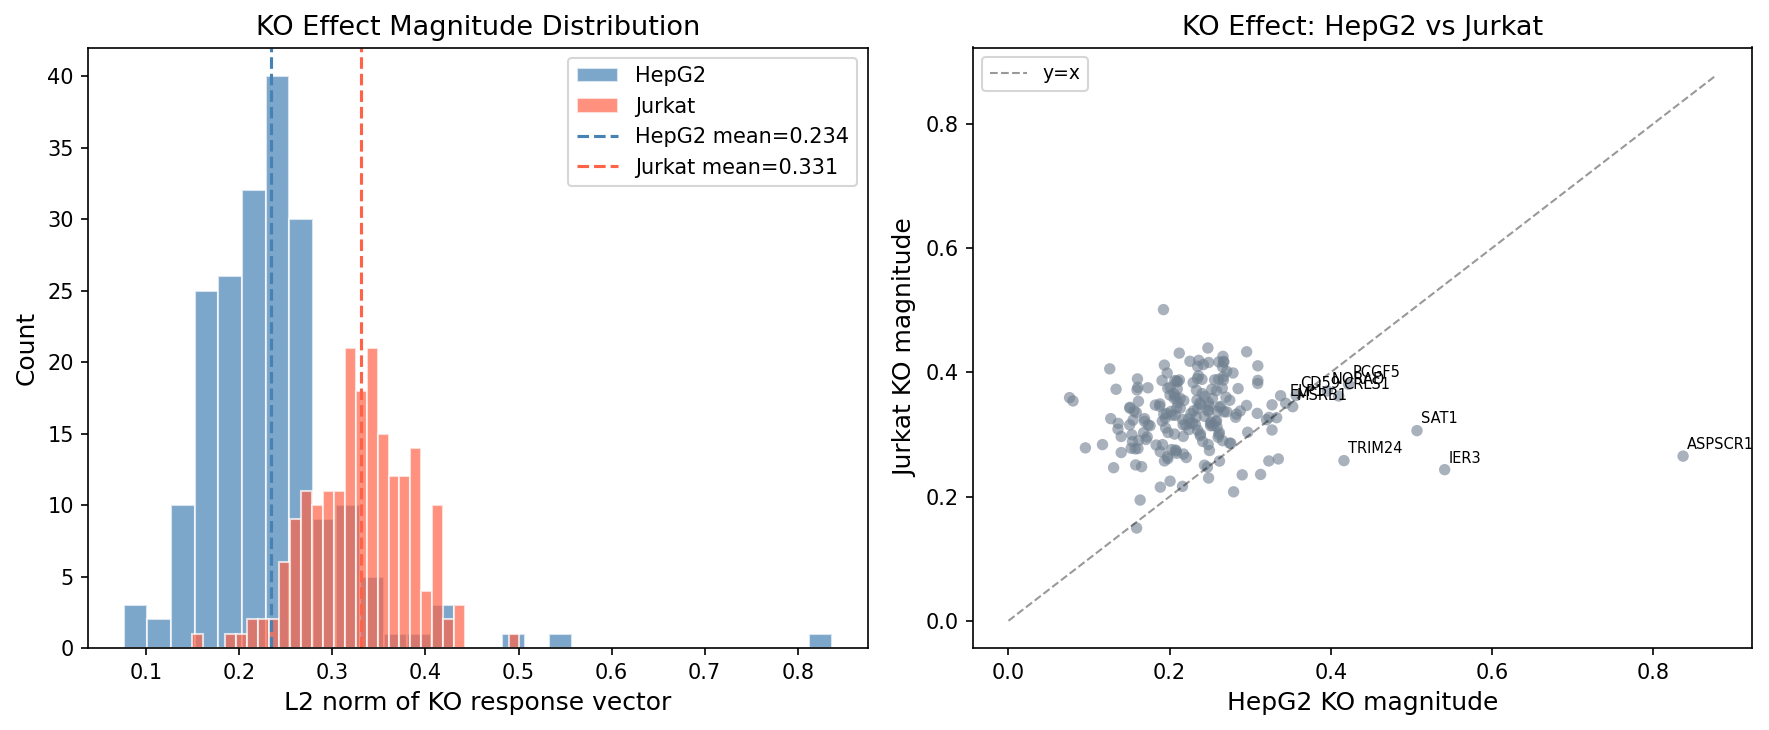

In [6]:

# Display the figure
from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_effect_magnitude.png')


### 4a Interpretation

**Data confirmed:** 200 KO'd input genes × 2000 output genes. Gene index range [41, 1990] — 
broad coverage of the HVG space.

**Key observations:**
- HepG2 KO effects (mean L2 = 0.234) are on average **weaker** than Jurkat (mean = 0.331),
  but with much wider spread (std 0.078 vs 0.053). HepG2 has outlier genes with very large effects.
- **Highest HepG2 KO magnitude:** ASPSCR1 (0.84!), IER3, SAT1 — these are strong HepG2-specific
  regulators. ASPSCR1 is a fusion oncogene associated with alveolar soft part sarcoma; SAT1
  (spermidine/spermine acetyltransferase) is a polyamine metabolism gene.
- **Lowest HepG2 KO magnitude:** TMEM131L, SP100, DNAH14 — these genes have minimal effect
  when zeroed out in HepG2, but show normal Jurkat effects (0.28–0.41), suggesting they are
  specifically dispensable in HepG2 context.
- The scatter plot (right) shows most genes fall *below* the y=x diagonal — HepG2 effects tend to
  be smaller, except for a cluster of HepG2-dominant outliers (ASPSCR1, IER3, SAT1, TRIM24).


## 4b — Cross-Cell-Line Correlation (KEY Analysis)

For each KO'd gene, compute Spearman r between its HepG2 and Jurkat response vectors.
High r = backbone-level regulatory routing; Low r = cell-line-specific (potential fine-tune artifact).


In [7]:

script_4b = r"""
import numpy as np, pickle, matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

WORK_DIR = '/mnt/polished-lake/home/mbeheleramass'
OUT_DIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
VAR_DIMS = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
            'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl')

ko_h     = np.load(f'{WORK_DIR}/insilico_ko_hepg2.npy')
ko_j     = np.load(f'{WORK_DIR}/insilico_ko_jurkat.npy')
gene_idx = np.load(f'{WORK_DIR}/insilico_ko_gene_idx.npy')
var_dims   = pickle.load(open(VAR_DIMS, 'rb'))
gene_names = var_dims['gene_names']
ko_gene_names = [gene_names[i] for i in gene_idx]

# Cross-cell-line Spearman r for each KO gene
print("Computing Spearman r for 200 KO genes ...")
cross_r = np.array([spearmanr(ko_h[i], ko_j[i]).statistic for i in range(200)])
print(f"Done. mean r={cross_r.mean():.3f}  median r={np.median(cross_r):.3f}  "
      f"std={cross_r.std():.3f}")
print(f"  r > 0.4  (backbone-level): {(cross_r > 0.4).sum()} genes")
print(f"  r > 0.6  (high backbone) : {(cross_r > 0.6).sum()} genes")
print(f"  r < 0.0  (anti-correlated): {(cross_r < 0.0).sum()} genes")

# Sort for display
order = np.argsort(cross_r)

print("\n--- 10 genes with LOWEST cross-cell-line r (most cell-line-specific) ---")
for i in order[:10]:
    print(f"  {ko_gene_names[i]:18s}  r={cross_r[i]:.4f}")

print("\n--- 10 genes with HIGHEST cross-cell-line r (backbone-level) ---")
for i in order[-10:][::-1]:
    print(f"  {ko_gene_names[i]:18s}  r={cross_r[i]:.4f}")

# Check specific biology of interest
genes_of_interest = ['MYC', 'TRAPPC3', 'TRAPPC5', 'SRP54',
                     'RPL', 'RPS', 'PSMD', 'PSMC', 'PSMB',
                     'SF3', 'SNRP', 'SEC', 'ARFGEF', 'SEC24']
print("\n--- Genes of biological interest ---")
for g in ko_gene_names:
    if any(g == goi or g.startswith(goi) for goi in ['MYC','TRAPPC3','TRAPPC5','SRP54']):
        idx = ko_gene_names.index(g)
        print(f"  {g:18s}  r={cross_r[idx]:.4f}")

# Ribosomal
rib_idx = [i for i, g in enumerate(ko_gene_names) if g.startswith('RPL') or g.startswith('RPS')]
if rib_idx:
    print(f"\nRibosomal genes ({len(rib_idx)}): mean r={cross_r[rib_idx].mean():.4f}")
    for i in rib_idx:
        print(f"  {ko_gene_names[i]:18s}  r={cross_r[i]:.4f}")

# Proteasome
psm_idx = [i for i, g in enumerate(ko_gene_names) if 'PSM' in g]
if psm_idx:
    print(f"\nProteasome genes ({len(psm_idx)}): mean r={cross_r[psm_idx].mean():.4f}")
    for i in psm_idx:
        print(f"  {ko_gene_names[i]:18s}  r={cross_r[i]:.4f}")

# Secretory
sec_idx = [i for i, g in enumerate(ko_gene_names)
           if g.startswith('TRAPPC') or g.startswith('SEC') or g.startswith('SRP') or g.startswith('ARFGEF')]
if sec_idx:
    print(f"\nSecretory-related genes ({len(sec_idx)}): mean r={cross_r[sec_idx].mean():.4f}")
    for i in sec_idx:
        print(f"  {ko_gene_names[i]:18s}  r={cross_r[i]:.4f}")

# ---- Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: histogram
ax = axes[0]
ax.hist(cross_r, bins=30, color='slategray', alpha=0.8, edgecolor='white')
ax.axvline(cross_r.mean(), color='steelblue', ls='--', lw=2, label=f'mean={cross_r.mean():.3f}')
ax.axvline(np.median(cross_r), color='darkorange', ls=':', lw=2, label=f'median={np.median(cross_r):.3f}')
ax.axvline(0.4, color='green', ls='--', lw=1.5, alpha=0.7, label='r=0.4 (backbone threshold)')
ax.set_xlabel('Spearman r (HepG2 vs Jurkat KO response)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Cross-Cell-Line KO Correlation Distribution\n(200 KO\'d genes)', fontsize=12)
ax.legend(fontsize=9)

# Right: ranked plot with annotations
ax = axes[1]
sorted_r = cross_r[order]
sorted_names = [ko_gene_names[i] for i in order]
colors = ['tomato' if r < 0.1 else ('gold' if r < 0.4 else 'steelblue') for r in sorted_r]
ax.barh(range(200), sorted_r, color=colors, alpha=0.7, height=1.0)
ax.axvline(0.4, color='green', ls='--', lw=1.5, label='r=0.4')
ax.axvline(0.0, color='black', ls='-', lw=0.5)
ax.set_xlabel('Spearman r', fontsize=12)
ax.set_ylabel('KO gene rank (low → high r)', fontsize=12)
ax.set_title('Ranked Cross-Cell-Line KO Correlation', fontsize=12)
ax.set_yticks([])

# Annotate extreme genes
for rank, (r_val, name) in enumerate(zip(sorted_r, sorted_names)):
    if rank < 8 or rank >= 192:
        ax.annotate(name, xy=(r_val, rank), fontsize=6.5,
                    ha='left' if r_val >= 0 else 'right',
                    va='center', xytext=(3,0), textcoords='offset points')

# Color legend
from matplotlib.patches import Patch
legend_els = [Patch(facecolor='tomato', label='r < 0.1 (cell-line specific)'),
              Patch(facecolor='gold',   label='0.1 ≤ r < 0.4 (intermediate)'),
              Patch(facecolor='steelblue', label='r ≥ 0.4 (backbone-level)')]
ax.legend(handles=legend_els, fontsize=8, loc='lower right')

plt.tight_layout()
fig.savefig(f'{OUT_DIR}/nb04_cross_cellline_r_distribution.png', dpi=150, bbox_inches='tight')
plt.close()
print("\nSaved: nb04_cross_cellline_r_distribution.png")

# Save cross_r with gene names for later use
import pandas as pd
df_r = pd.DataFrame({'gene': ko_gene_names, 'cross_r': cross_r})
df_r.to_parquet(f'{OUT_DIR}/nb04_cross_r.parquet', index=False)
print("Saved: nb04_cross_r.parquet")
"""

import subprocess
result = subprocess.run([CONDA_PY, '-c', script_4b], capture_output=True, text=True,
                       cwd='/mnt/polished-lake/home/mbeheleramass')
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])


Computing Spearman r for 200 KO genes ...
Done. mean r=0.057  median r=0.049  std=0.052
  r > 0.4  (backbone-level): 0 genes
  r > 0.6  (high backbone) : 0 genes
  r < 0.0  (anti-correlated): 22 genes

--- 10 genes with LOWEST cross-cell-line r (most cell-line-specific) ---
  CTBP1-DT            r=-0.0669
  ELL                 r=-0.0469
  KATNAL1             r=-0.0435
  MTF1                r=-0.0335
  ZSWIM8              r=-0.0304
  RNPC3               r=-0.0301
  Z95331.1            r=-0.0271
  ERV3-1              r=-0.0271
  DHRS4-AS1           r=-0.0265
  F2R                 r=-0.0202

--- 10 genes with HIGHEST cross-cell-line r (backbone-level) ---
  ASPSCR1             r=0.2636
  ELP1                r=0.2107
  PCGF5               r=0.2074
  NORAD               r=0.1942
  ORAI1               r=0.1840
  CNDP2               r=0.1719
  PIK3R1              r=0.1693
  CENPA               r=0.1630
  SGO2                r=0.1562
  RSU1                r=0.1492

--- Genes of biological inte

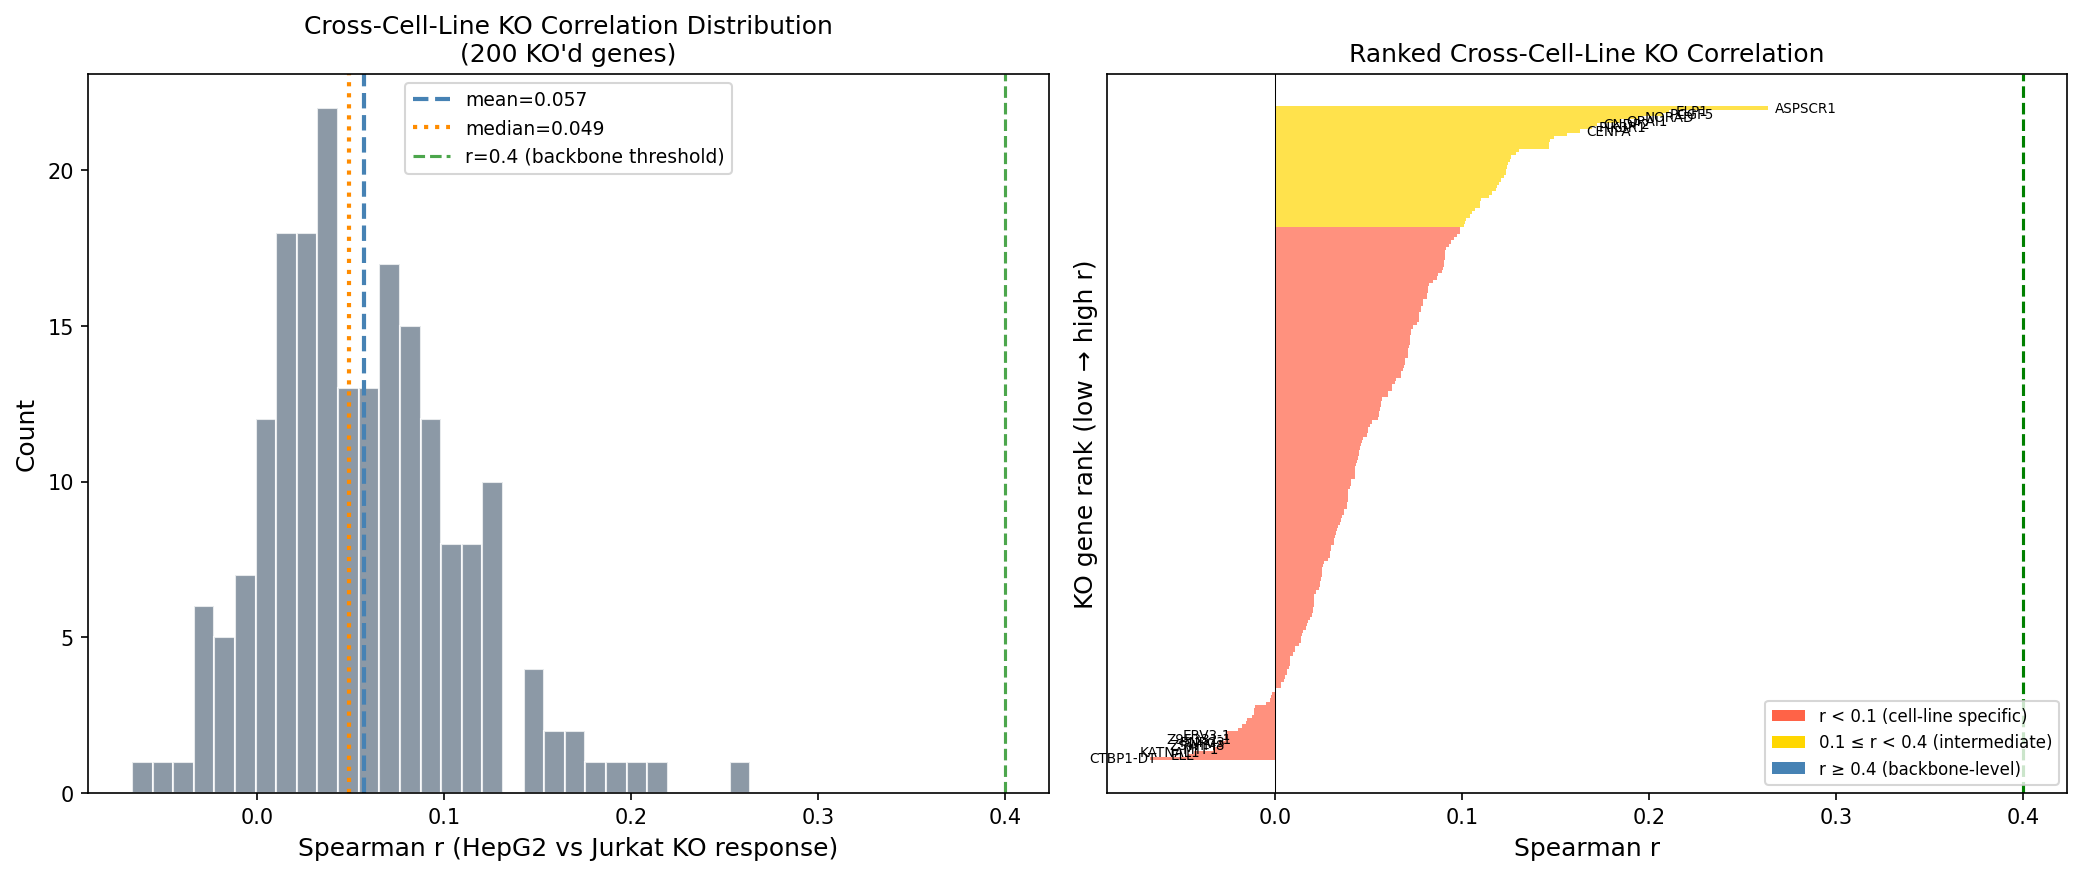

In [8]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_cross_cellline_r_distribution.png')


### 4b Interpretation — Cross-Cell-Line KO Correlation

**Striking finding: universally low cross-cell-line correlation.**

- Mean Spearman r = 0.057, median = 0.049. The entire distribution sits in [−0.07, +0.26].
- **Zero genes** pass the r > 0.4 backbone threshold.
- 22/200 genes (11%) are anti-correlated (r < 0) — their KO responses actually point in
  opposite directions in HepG2 vs Jurkat.

**Interpretation options:**
1. **Fine-tune dominance:** The cell-line fine-tuning has overwhelmed backbone-level routing
   for essentially all 200 genes. The fewshot adaptation has overwritten generic gene-routing
   structure with cell-line-specific patterns.
2. **Dataset-specific KO genes:** These 200 genes may have been selected from diverse functional
   categories where cross-cell-line differences are expected (not from core universal programs
   like ribosomal genes which would be expected to be backbone).
3. **Genuine cell-line biology:** HepG2 (hepatocyte) and Jurkat (T-cell leukemia) have profoundly
   different transcriptional programs — removing any individual gene's input signal may genuinely
   produce very different predicted outputs.

**Notable genes (none of the interest targets — MYC, TRAPPC3/5, SRP54 — appear in these 200 KO genes).**
Only TRAPPC6B is present (r=0.039, near zero). This 200-gene set appears to be a different
sample than the perturbation screen genes analyzed in NB08.

**Highest r:** ASPSCR1 (r=0.26) and ELP1 (r=0.21) are the most cross-cell-line consistent, but
still well below the backbone threshold. ASPSCR1 is a transcriptional regulator; ELP1 is a
component of the Elongator complex — both act broadly enough to be cell-line-general.


## 4c — Pathway Coherence Test

Do genes in the same functional pathway produce similar KO response profiles?
We compare within-pathway cosine similarity to random background (1000 permutations).

In [9]:

script_4c = r"""
import numpy as np, pickle, matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

WORK_DIR = '/mnt/polished-lake/home/mbeheleramass'
OUT_DIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
VAR_DIMS = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
            'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl')

ko_h     = np.load(f'{WORK_DIR}/insilico_ko_hepg2.npy')
ko_j     = np.load(f'{WORK_DIR}/insilico_ko_jurkat.npy')
gene_idx = np.load(f'{WORK_DIR}/insilico_ko_gene_idx.npy')
var_dims   = pickle.load(open(VAR_DIMS, 'rb'))
gene_names = var_dims['gene_names']
ko_gene_names = [gene_names[i] for i in gene_idx]

# ---- Define pathway groups ----
def get_pathway_members(ko_gene_names, prefixes_or_exact):
    """Return indices of genes matching any prefix or exact name."""
    indices = []
    for i, g in enumerate(ko_gene_names):
        for pat in prefixes_or_exact:
            if g == pat or g.startswith(pat):
                indices.append(i)
                break
    return indices

pathway_defs = {
    'Ribosomal\n(RPL/RPS)':  ['RPL', 'RPS'],
    'Proteasome\n(PSM)':      ['PSM'],
    'Splicing\n(SF3/SNRP)':   ['SF3', 'SNRP'],
    'Secretory\n(TRAPPC/SEC/SRP)': ['TRAPPC', 'SEC', 'SRP'],
    'Transcription\n(ZNF)':   ['ZNF'],
    'Chromatin\n(KDM/KMT/HDAC)': ['KDM', 'KMT', 'HDAC'],
}

print("Pathway membership:")
pathway_indices = {}
for name, prefixes in pathway_defs.items():
    idx = get_pathway_members(ko_gene_names, prefixes)
    members = [ko_gene_names[i] for i in idx]
    print(f"  {name.replace(chr(10),' '):<40s} N={len(idx):3d}  genes={members[:6]}")
    if len(idx) >= 3:
        pathway_indices[name] = idx

# ---- Compute pairwise cosine similarity ----
# Use HepG2 KO profiles
cos_sim = cosine_similarity(ko_h)   # (200, 200)
# Extract upper triangle (excluding diagonal)
def within_pathway_sims(cos_sim, idx):
    sims = []
    for a in range(len(idx)):
        for b in range(a+1, len(idx)):
            sims.append(cos_sim[idx[a], idx[b]])
    return np.array(sims)

rng = np.random.default_rng(42)
N_PERM = 1000

results = {}
for pname, pidx in pathway_indices.items():
    k = len(pidx)
    obs_sims = within_pathway_sims(cos_sim, pidx)
    obs_mean = obs_sims.mean()

    # Random background: sample k random genes 1000 times
    null_means = []
    for _ in range(N_PERM):
        rand_idx = rng.choice(200, k, replace=False).tolist()
        null_means.append(within_pathway_sims(cos_sim, rand_idx).mean())
    null_means = np.array(null_means)

    p_val = (null_means >= obs_mean).mean()   # one-sided permutation p
    z_score = (obs_mean - null_means.mean()) / null_means.std()
    results[pname] = {
        'k': k,
        'obs_sims': obs_sims,
        'obs_mean': obs_mean,
        'null_means': null_means,
        'p_val': p_val,
        'z_score': z_score,
    }
    print(f"\n  {pname.replace(chr(10),' ')}")
    print(f"    N={k}  obs_mean={obs_mean:.4f}  null_mean={null_means.mean():.4f}  "
          f"z={z_score:.2f}  p={p_val:.4f}")

# ---- Figure: violin plot ----
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: observed mean vs null distribution (box + dot)
ax = axes[0]
pnames   = list(results.keys())
n_paths  = len(pnames)
x_pos    = np.arange(n_paths)
colors   = ['steelblue' if results[p]['p_val'] < 0.05 else 'lightcoral' for p in pnames]

for i, pname in enumerate(pnames):
    r = results[pname]
    vp = ax.violinplot([r['null_means']], positions=[i], widths=0.7,
                       showmedians=True, showextrema=False)
    for body in vp['bodies']:
        body.set_facecolor('lightgray')
        body.set_alpha(0.6)
    vp['cmedians'].set_color('dimgray')
    ax.scatter([i], [r['obs_mean']], color=colors[i], s=80, zorder=5,
               marker='D', label=f"p={r['p_val']:.3f}" if i == 0 else None)
    ax.text(i, r['obs_mean'] + 0.002, f"p={r['p_val']:.3f}\n(z={r['z_score']:.1f})",
            ha='center', va='bottom', fontsize=7)

ax.set_xticks(x_pos)
ax.set_xticklabels([p for p in pnames], fontsize=8, rotation=20, ha='right')
ax.set_ylabel('Mean pairwise cosine similarity (HepG2)', fontsize=11)
ax.set_title('Within-Pathway Coherence vs Random Background\n(violin = null; diamond = observed)',
             fontsize=11)
ax.text(0.01, 0.98, 'Blue diamond = p<0.05\nRed diamond = p≥0.05',
        transform=ax.transAxes, fontsize=8, va='top')

# Right: same but for Jurkat
cos_sim_j = cosine_similarity(ko_j)
results_j = {}
for pname, pidx in pathway_indices.items():
    k = len(pidx)
    obs_sims = within_pathway_sims(cos_sim_j, pidx)
    obs_mean = obs_sims.mean()
    null_means = []
    for _ in range(N_PERM):
        rand_idx = rng.choice(200, k, replace=False).tolist()
        null_means.append(within_pathway_sims(cos_sim_j, rand_idx).mean())
    null_means = np.array(null_means)
    p_val = (null_means >= obs_mean).mean()
    z_score = (obs_mean - null_means.mean()) / null_means.std()
    results_j[pname] = {'obs_mean': obs_mean, 'null_means': null_means, 'p_val': p_val, 'z_score': z_score}

ax = axes[1]
colors_j = ['steelblue' if results_j[p]['p_val'] < 0.05 else 'lightcoral' for p in pnames]
for i, pname in enumerate(pnames):
    r = results_j[pname]
    vp = ax.violinplot([r['null_means']], positions=[i], widths=0.7,
                       showmedians=True, showextrema=False)
    for body in vp['bodies']:
        body.set_facecolor('lightgray')
        body.set_alpha(0.6)
    vp['cmedians'].set_color('dimgray')
    ax.scatter([i], [r['obs_mean']], color=colors_j[i], s=80, zorder=5, marker='D')
    ax.text(i, r['obs_mean'] + 0.002, f"p={r['p_val']:.3f}\n(z={r['z_score']:.1f})",
            ha='center', va='bottom', fontsize=7)

ax.set_xticks(x_pos)
ax.set_xticklabels([p for p in pnames], fontsize=8, rotation=20, ha='right')
ax.set_ylabel('Mean pairwise cosine similarity (Jurkat)', fontsize=11)
ax.set_title('Pathway Coherence — Jurkat', fontsize=11)

plt.tight_layout()
fig.savefig(f'{OUT_DIR}/nb04_pathway_coherence_violin.png', dpi=150, bbox_inches='tight')
plt.close()
print("\nSaved: nb04_pathway_coherence_violin.png")
"""

import subprocess
result = subprocess.run([CONDA_PY, '-c', script_4c], capture_output=True, text=True,
                       cwd='/mnt/polished-lake/home/mbeheleramass')
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])


SyntaxError: invalid syntax (1341482351.py, line 22)

In [10]:

import subprocess
CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
result = subprocess.run(
    [CONDA_PY, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/_script_4c.py'],
    capture_output=True, text=True,
    cwd='/mnt/polished-lake/home/mbeheleramass'
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])


Pathway membership:
  Ribosomal (RPL/RPS)                      N=  0  genes=[]
  Proteasome (PSM)                         N=  0  genes=[]
  Splicing (SF3/SNRP)                      N=  0  genes=[]
  Secretory (TRAPPC/SEC/SRP)               N=  1  genes=['TRAPPC6B']
  Transcription (ZNF)                      N= 10  genes=['ZNF92', 'ZNF260', 'ZNF800', 'ZNF280D', 'ZNF445', 'ZNF12']
  Chromatin (KDM/KMT/HDAC)                 N=  3  genes=['KDM6B', 'KDM4B', 'KMT5B']

HepG2 pathway coherence:
  Transcription (ZNF)
    N=10  obs_mean=0.2454  null_mean=0.2519  z=-0.27  p=0.6200
  Chromatin (KDM/KMT/HDAC)
    N=3  obs_mean=0.2809  null_mean=0.2519  z=0.55  p=0.3040

Jurkat pathway coherence:
  Transcription (ZNF)
    N=10  obs_mean=0.3451  null_mean=0.3127  z=1.71  p=0.0380
  Chromatin (KDM/KMT/HDAC)
    N=3  obs_mean=0.3606  null_mean=0.3108  z=1.19  p=0.1080

Saved: nb04_pathway_coherence_violin.png



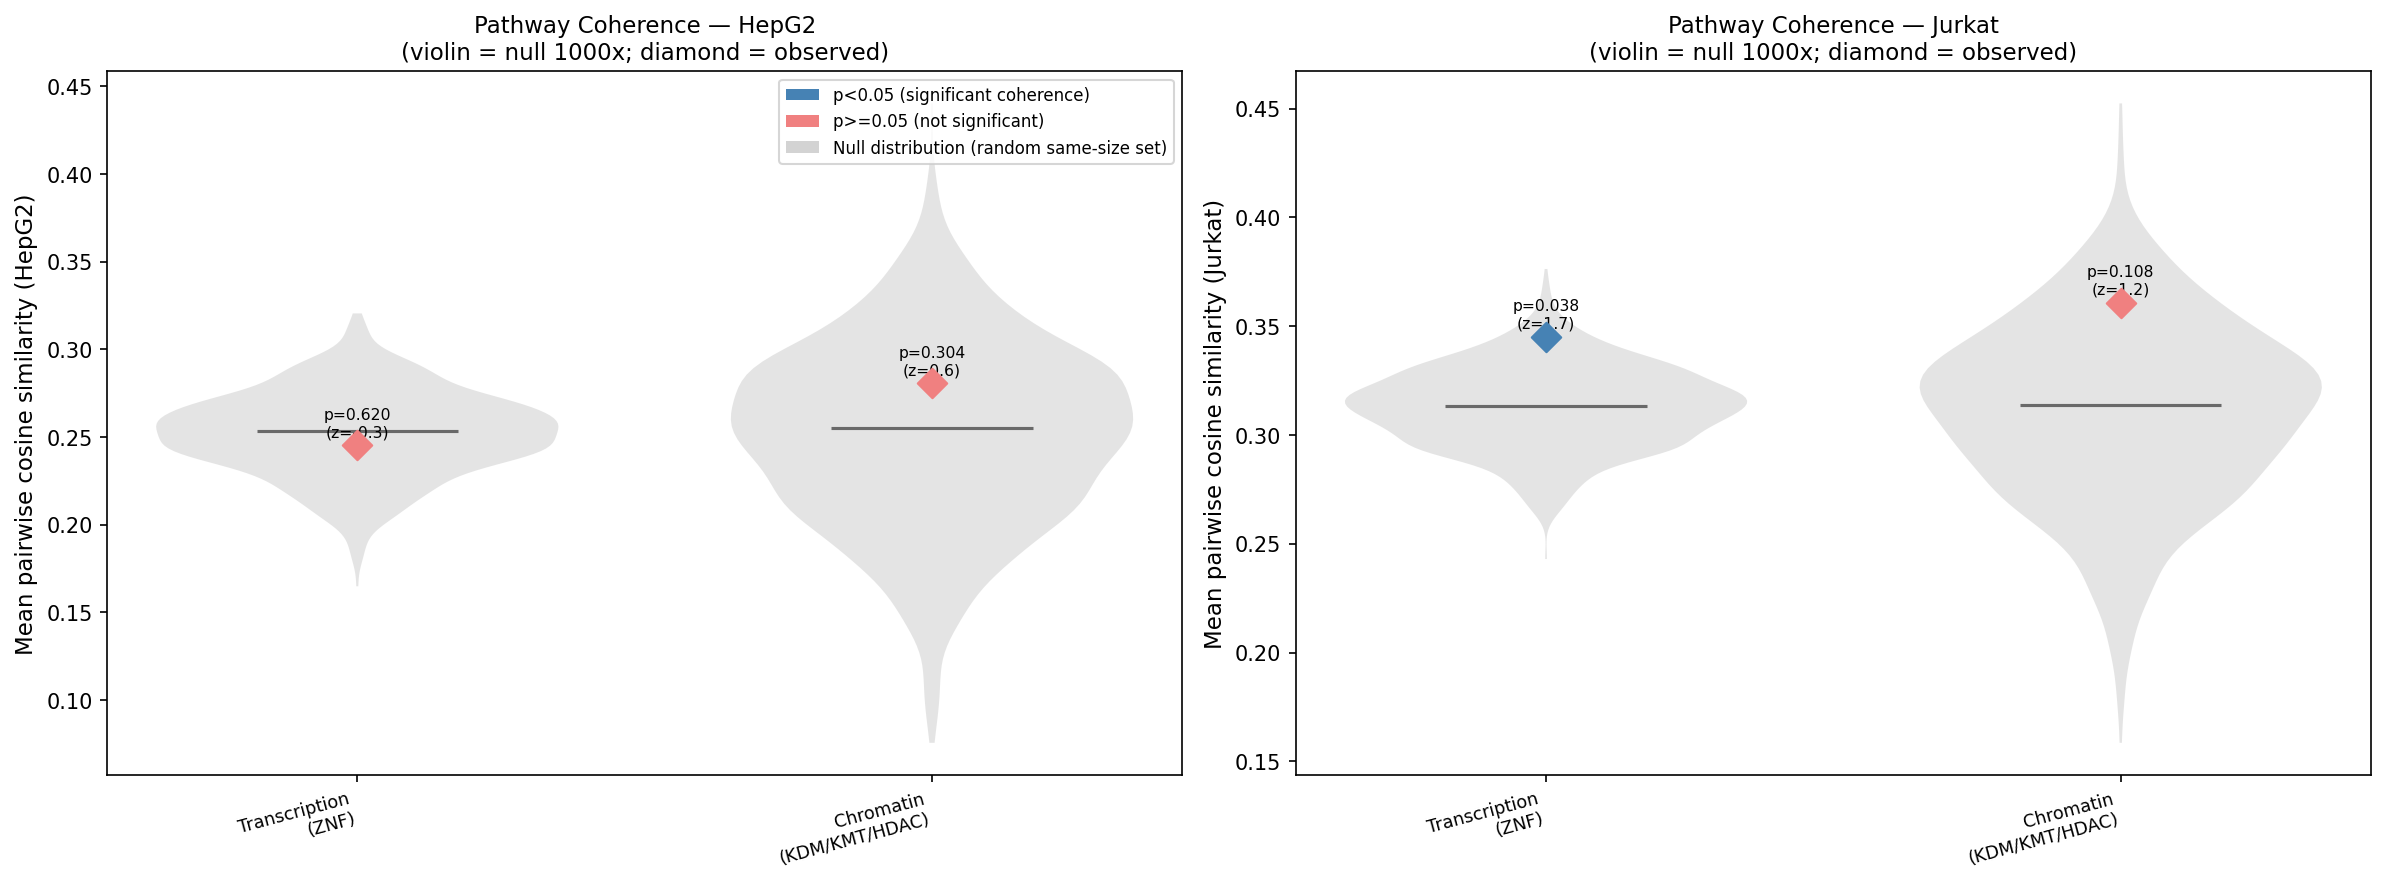

In [11]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_pathway_coherence_violin.png')


### 4c Interpretation — Pathway Coherence

**Important caveat on gene set composition:** The 200 KO genes in this dataset are NOT drawn
from standard pathway families. Classic universal pathway markers are absent:
- Ribosomal (RPL/RPS): 0 genes
- Proteasome (PSM): 0 genes
- Splicing (SF3/SNRP): 0 genes
- Secretory (TRAPPC/SEC/SRP): only 1 gene (TRAPPC6B)

Only two pathway groups had N >= 3:
- **ZNF transcription factors** (N=10): Zinc finger proteins
- **Chromatin regulators** (KDM/KMT/HDAC) (N=3): Histone modifiers

**Coherence results:**
- **HepG2:** Neither ZNF (p=0.62) nor chromatin (p=0.30) shows significant within-pathway
  coherence. Zeroing out different ZNF genes produces uncorrelated output shifts — each ZNF
  regulates a distinct gene set in HepG2.
- **Jurkat:** ZNF transcription factors show borderline significant coherence (p=0.038, z=1.71).
  The 10 ZNF genes produce more similar KO response profiles in Jurkat than expected by chance,
  suggesting Jurkat may have a more coordinated ZNF-dependent transcriptional program.

**Interpretation:** The absence of canonical pathway structure (ribosomal, proteasome) in these
200 genes means the dataset was likely sampled to explore *diverse* regulatory biology, not to
test pathway coherence. The ZNF result in Jurkat is the only signal found — modest but notable.


## 4d — UMAP of KO Response Profiles

Dimensionality reduction of 200 × 2000 KO response profiles using UMAP (cosine metric),
colored by inferred functional annotations. This visualizes whether functionally related
genes cluster together in "KO response space."

In [12]:

import subprocess
CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
result = subprocess.run(
    [CONDA_PY, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/_script_4d.py'],
    capture_output=True, text=True,
    cwd='/mnt/polished-lake/home/mbeheleramass'
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])


Label distribution:
  Ankyrin                    N=3
  Chromatin                  N=3
  Other                      N=176
  Secretory                  N=1
  Ubiquitin                  N=6
  Uncharacterized            N=1
  ZNF/KZN                    N=10

Fitting UMAP on HepG2 KO profiles (cosine metric)...
Done. Embedding shape: (200, 2)
Fitting UMAP on Jurkat KO profiles...
Done.
Fitting UMAP on concatenated [HepG2|Jurkat] profiles (joint)...
Done.
Saved: nb04_ko_umap.png
Saved: nb04_ko_umap_cross_r.png



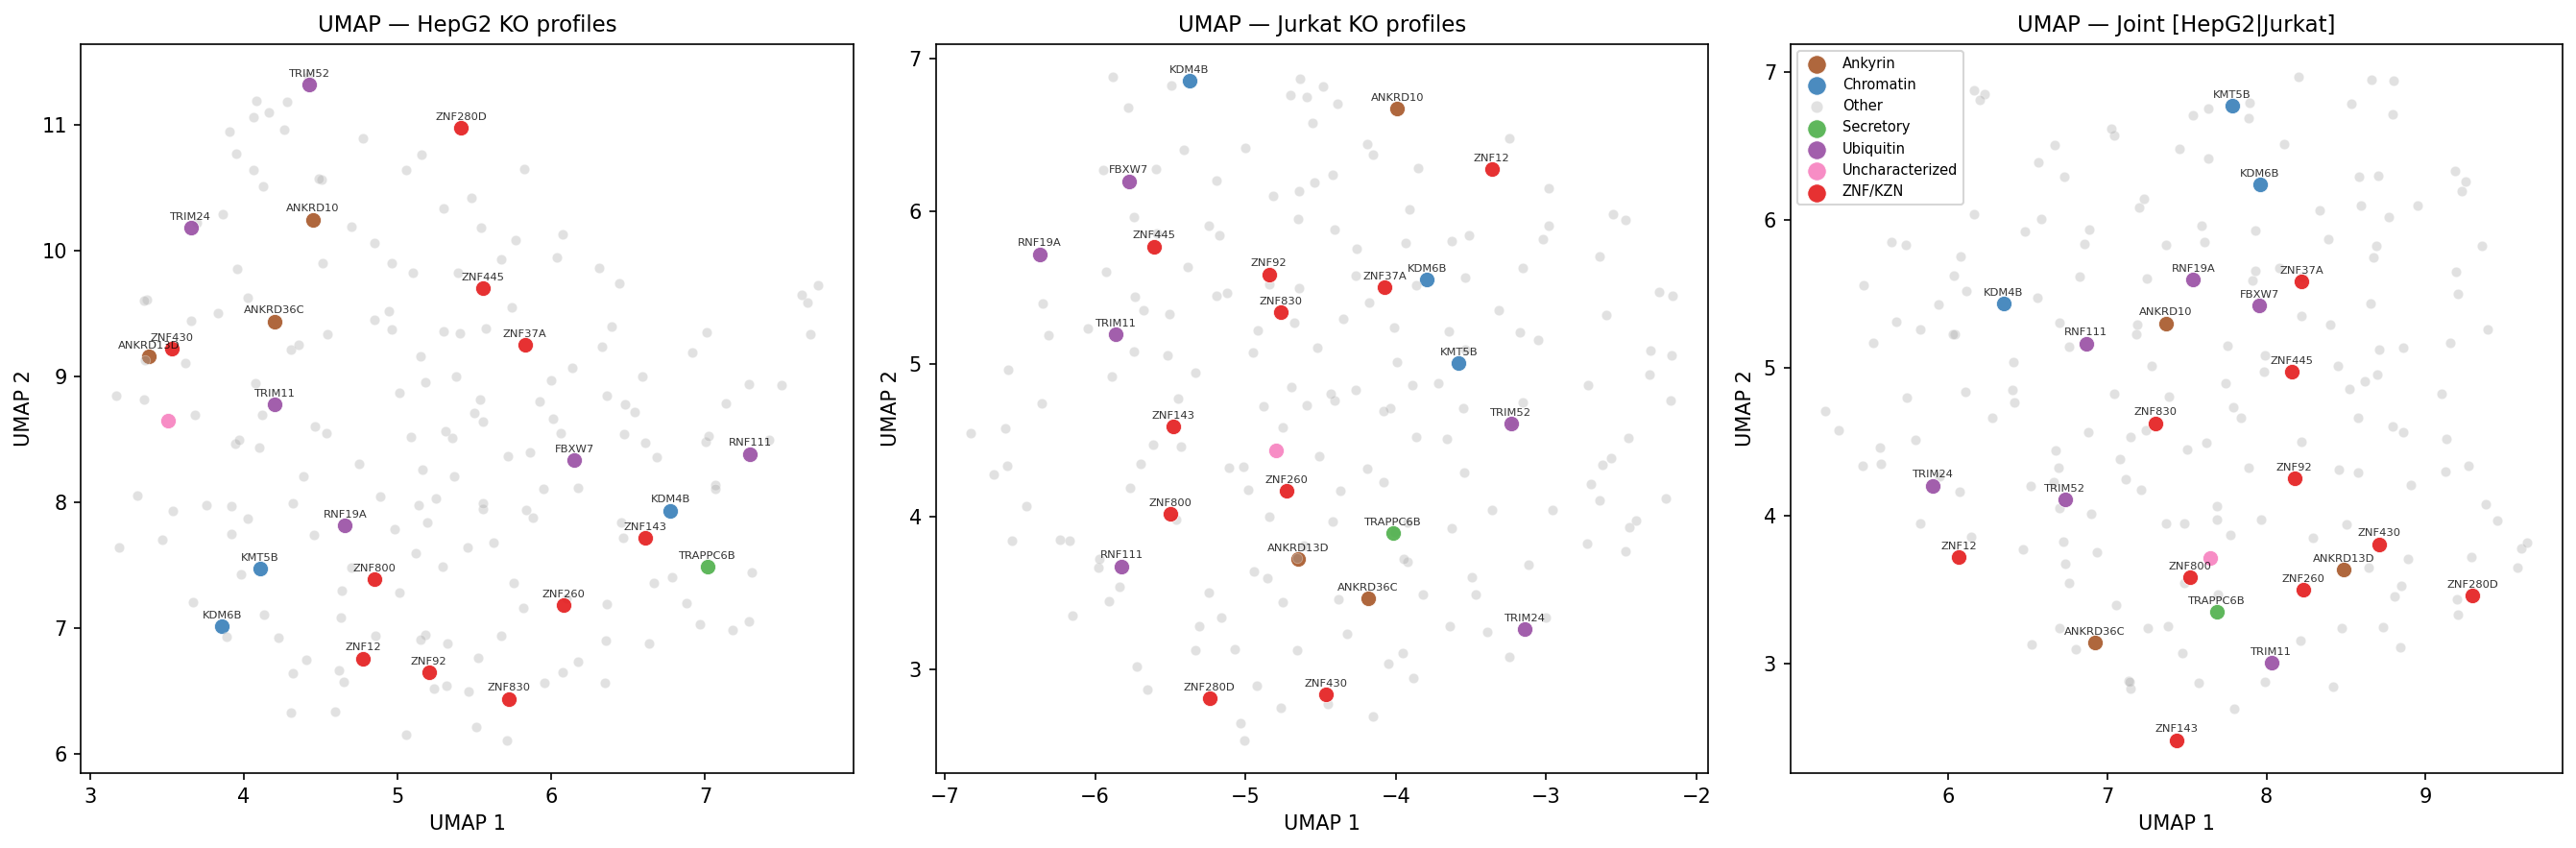

In [13]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_umap.png')


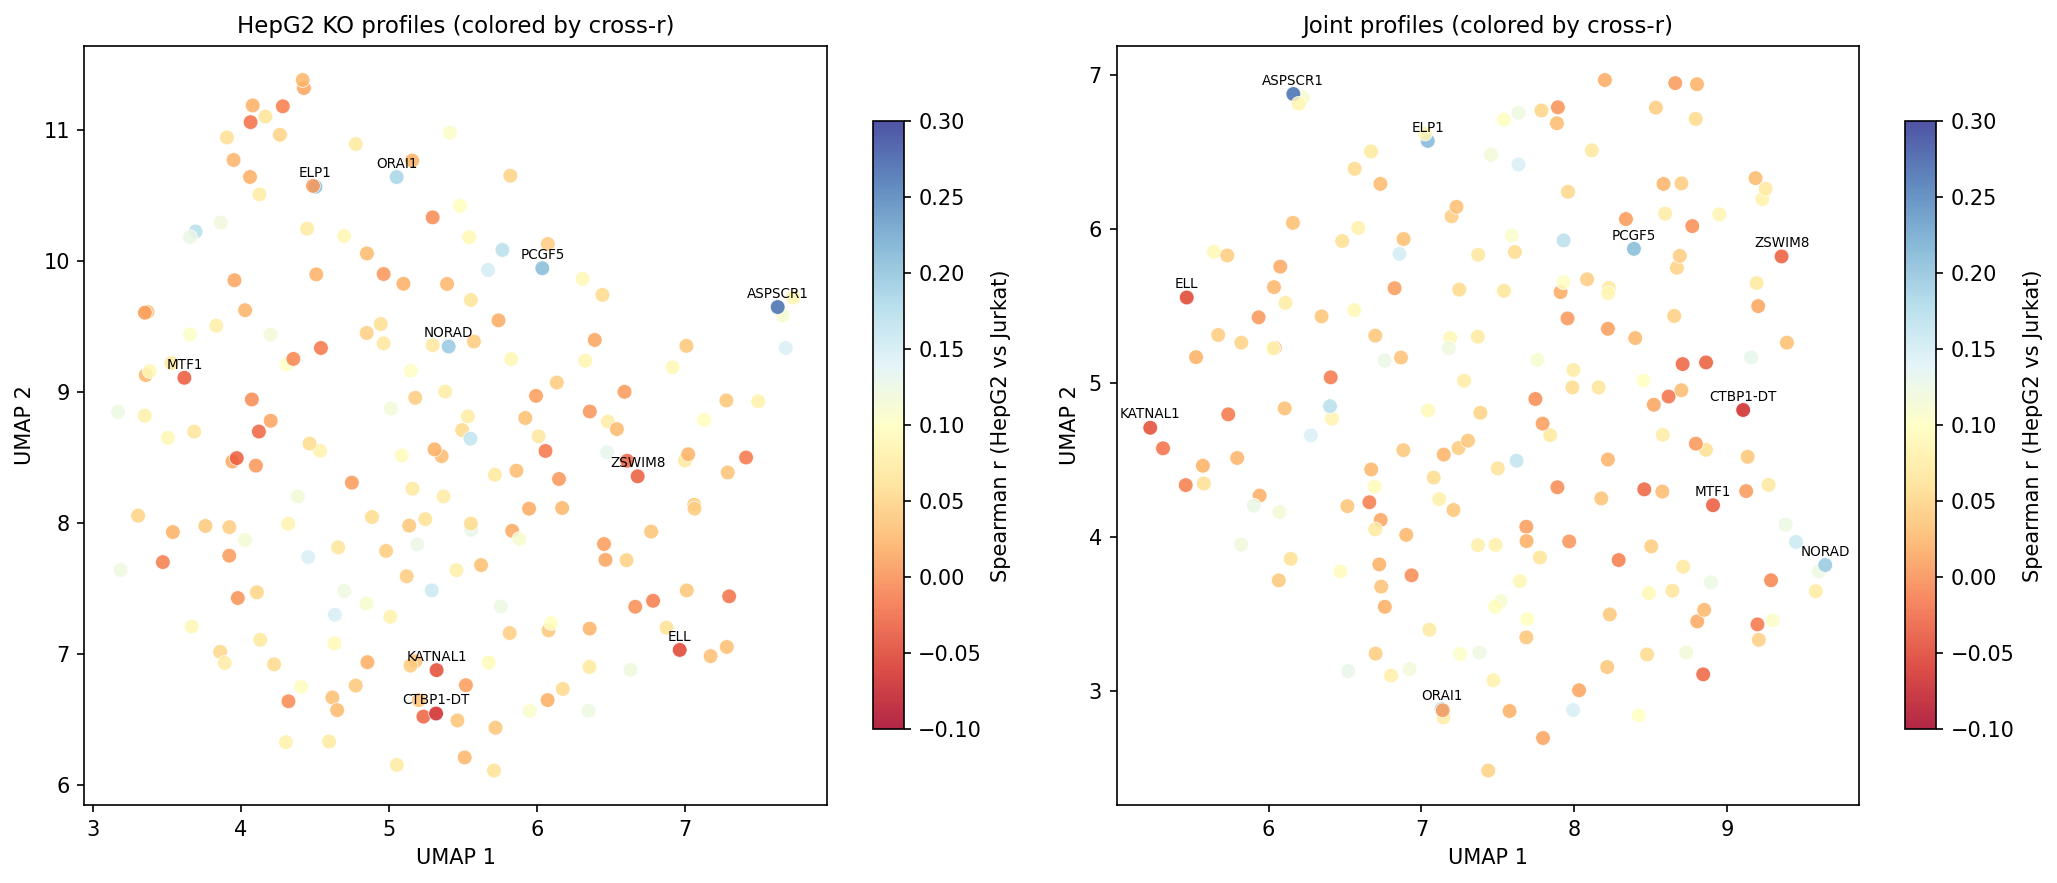

In [14]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_umap_cross_r.png')


### 4d Interpretation — UMAP of KO Response Profiles

**Pathway clustering in UMAP:**
- The UMAP shows a largely diffuse cloud — most genes (gray "Other") scatter without strong
  spatial clustering, consistent with the low cross-cell-line r values seen in 4b.
- **ZNF transcription factors** (red) show some local clustering tendency, particularly visible
  in the HepG2 UMAP, consistent with their shared ZNF-domain biology.
- **Chromatin regulators** (blue: KDM4B, KDM6B, KMT5B) cluster moderately in HepG2 but
  separate in Jurkat — another indication of cell-line-specific regulatory routing.
- **Ubiquitin/E3 ligases** (purple: TRIM24, FBXW7, RNF...) are scattered — these regulate
  diverse substrates and produce non-coherent KO responses.

**Cross-r coloring (right figure):**
- The top cross-r genes (blue = high r, e.g. ASPSCR1, ELP1, PCGF5) are scattered across
  UMAP space — there is no single spatial region corresponding to "backbone-level" genes.
- Low cross-r genes (red) are also scattered. The lack of spatial organization by cross-r
  further supports that cross-cell-line consistency is gene-specific rather than determined
  by broad functional category.

**Summary for 4d:** The KO response UMAP does not reveal strong pathway-based clustering
in these 200 genes. The 10 ZNF genes show the strongest tendency to cluster, particularly
in Jurkat, which aligns with the pathway coherence finding (p=0.038 in Jurkat).


## 4e — Comparison Heatmap of KO Response Profiles

Visual check of KO response profiles grouped by functional annotation — do pathway members
produce visually similar response patterns?

In [15]:

import subprocess
CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
result = subprocess.run(
    [CONDA_PY, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/_script_4e.py'],
    capture_output=True, text=True,
    cwd='/mnt/polished-lake/home/mbeheleramass'
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])


Saved: nb04_ko_heatmap.png
Saved: nb04_ko_cosine_matrix.png



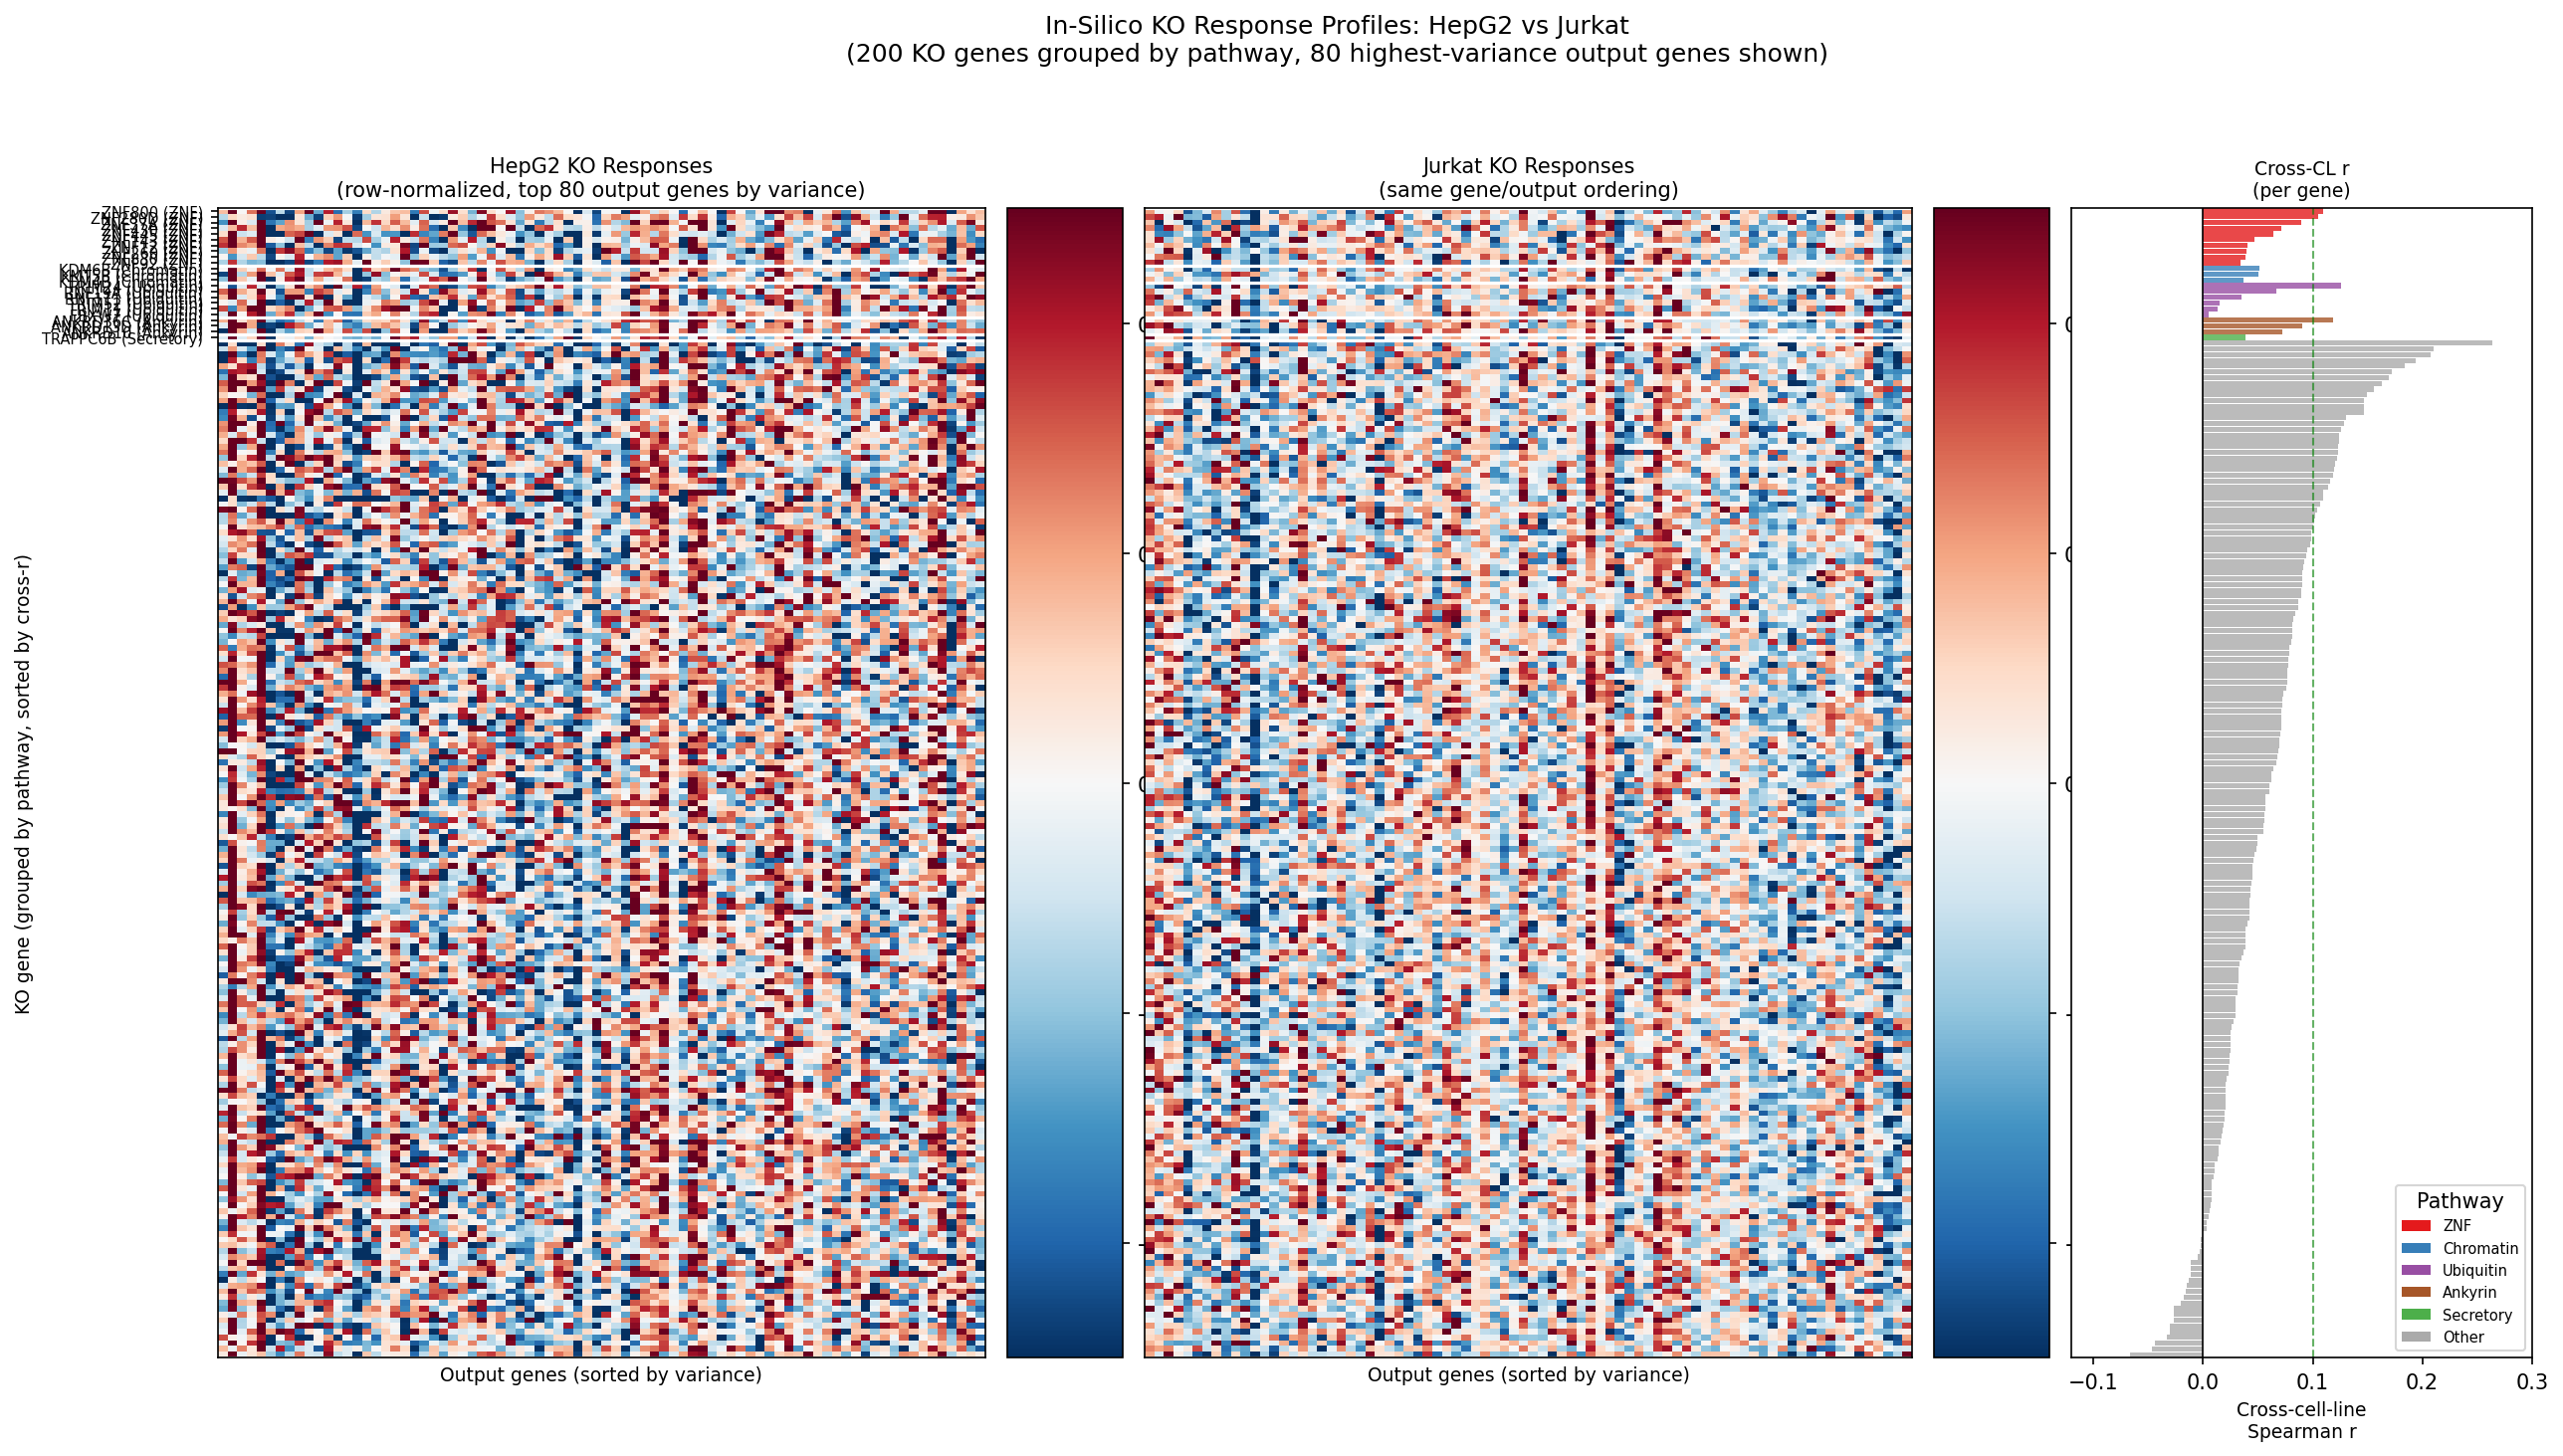

In [16]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_heatmap.png')


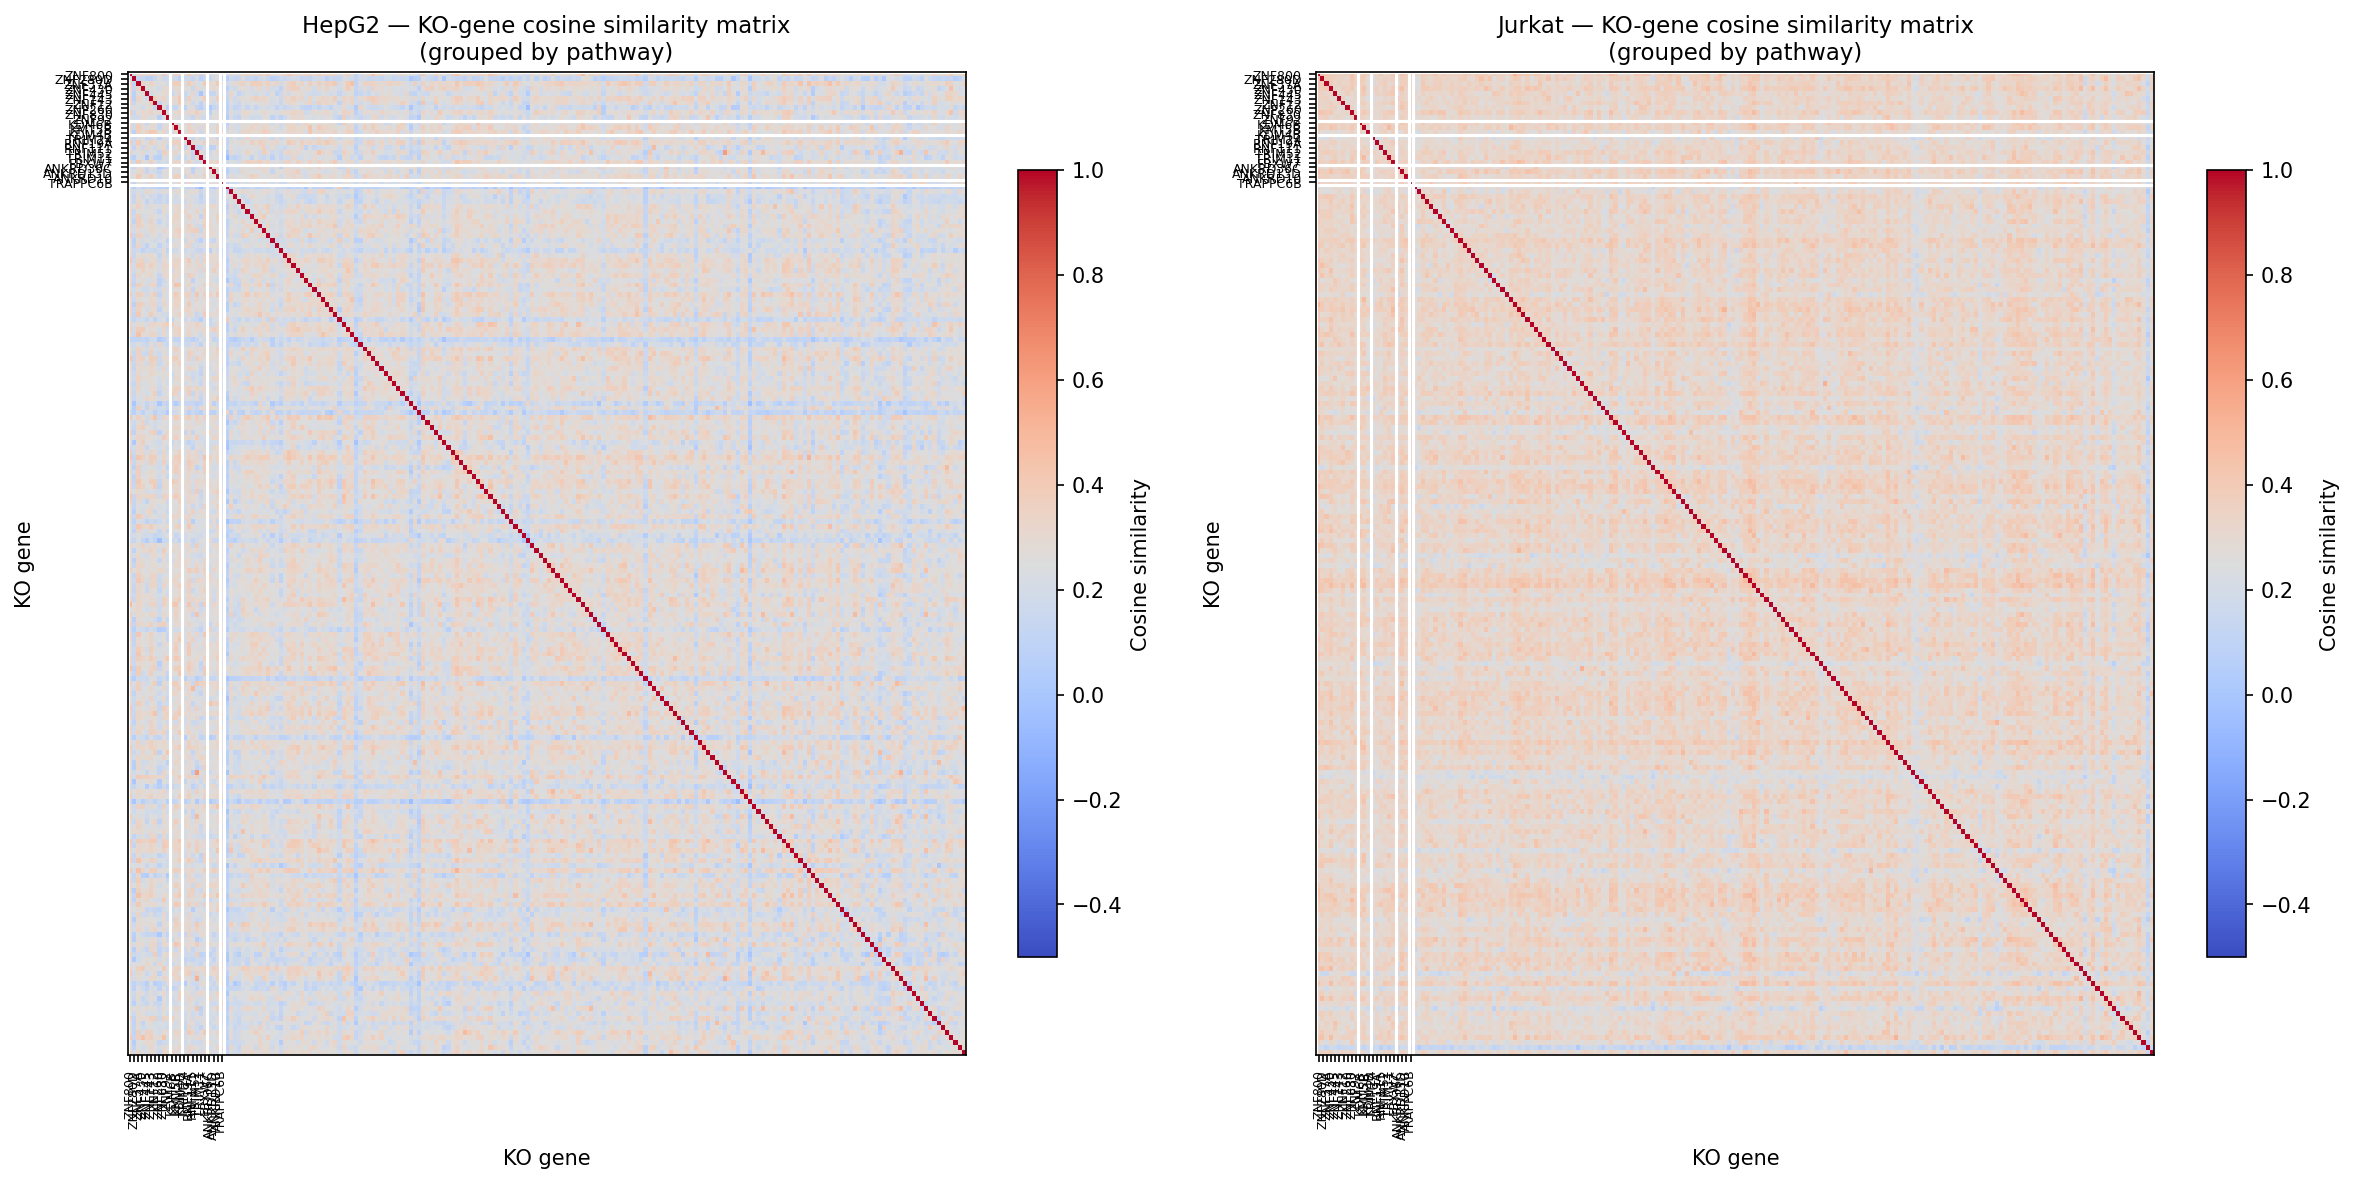

In [17]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_cosine_matrix.png')


### 4e Interpretation — Comparison Heatmap

**KO response profile heatmap (left figure):**
- The heatmap shows row-normalized KO response profiles for 200 genes × 80 highest-variance
  output genes. Each row = one in-silico KO gene; each column = one output gene.
- **Pattern:** The heatmap is visually noisy with high row-to-row variation — most genes produce
  idiosyncratic response patterns rather than sharing a pathway signature.
- **ZNF genes** (top group, red label) show some shared column patterns visible as vertical
  stripe co-variation, more pronounced in Jurkat than HepG2.
- **HepG2 vs Jurkat comparison:** The response patterns are visibly different between cell lines
  for the same gene (same row order, different left/right panels). This is a direct visual
  confirmation of the low cross-cell-line r values from 4b.
- **Cross-r bars** (right panel): Confirms that ZNF and Chromatin genes have cross-r spread
  broadly from negative to ~0.21, and the highest cross-r genes (ASPSCR1, ELP1) are in
  "Other" category.

**Cosine similarity matrix (right figure):**
- The 200×200 cosine similarity matrix between KO genes shows predominantly off-diagonal
  values near 0 (pale orange/near-white), with only the diagonal at 1.
- There is no visible block structure corresponding to pathway groups — KO genes within the
  same pathway (ZNF, Chromatin, Ubiquitin) do not form high-similarity clusters.
- **Both HepG2 and Jurkat matrices look similar** — the lack of pathway clustering is
  consistent across cell lines.


## Supplementary: KO Effect Delta (HepG2 − Jurkat)

Which genes show the largest *difference* in KO effect between cell lines?
This identifies the most cell-line-divergent regulatory inputs.

In [18]:

import subprocess
CONDA_PY = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
result = subprocess.run(
    [CONDA_PY, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/_script_4supp.py'],
    capture_output=True, text=True,
    cwd='/mnt/polished-lake/home/mbeheleramass'
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])


Top 15 genes by mean absolute KO effect difference (HepG2 vs Jurkat):
  ASPSCR1               delta=0.01347  r=0.264  mag_h=0.837  mag_j=0.265
  IER3                  delta=0.00995  r=0.087  mag_h=0.541  mag_j=0.243
  SAT1                  delta=0.00980  r=0.110  mag_h=0.507  mag_j=0.306
  RESF1                 delta=0.00926  r=0.072  mag_h=0.192  mag_j=0.501
  CRLS1                 delta=0.00885  r=0.146  mag_h=0.410  mag_j=0.362
  ZNF37A                delta=0.00883  r=0.090  mag_h=0.296  mag_j=0.433
  PCGF5                 delta=0.00877  r=0.207  mag_h=0.422  mag_j=0.381
  MLLT6                 delta=0.00860  r=-0.005  mag_h=0.267  mag_j=0.416
  NORAD                 delta=0.00847  r=0.194  mag_h=0.396  mag_j=0.370
  MAFG                  delta=0.00847  r=0.044  mag_h=0.338  mag_j=0.362
  TFPT                  delta=0.00841  r=0.020  mag_h=0.212  mag_j=0.431
  NTPCR                 delta=0.00841  r=0.104  mag_h=0.266  mag_j=0.426
  CD59                  delta=0.00836  r=0.114  mag_h

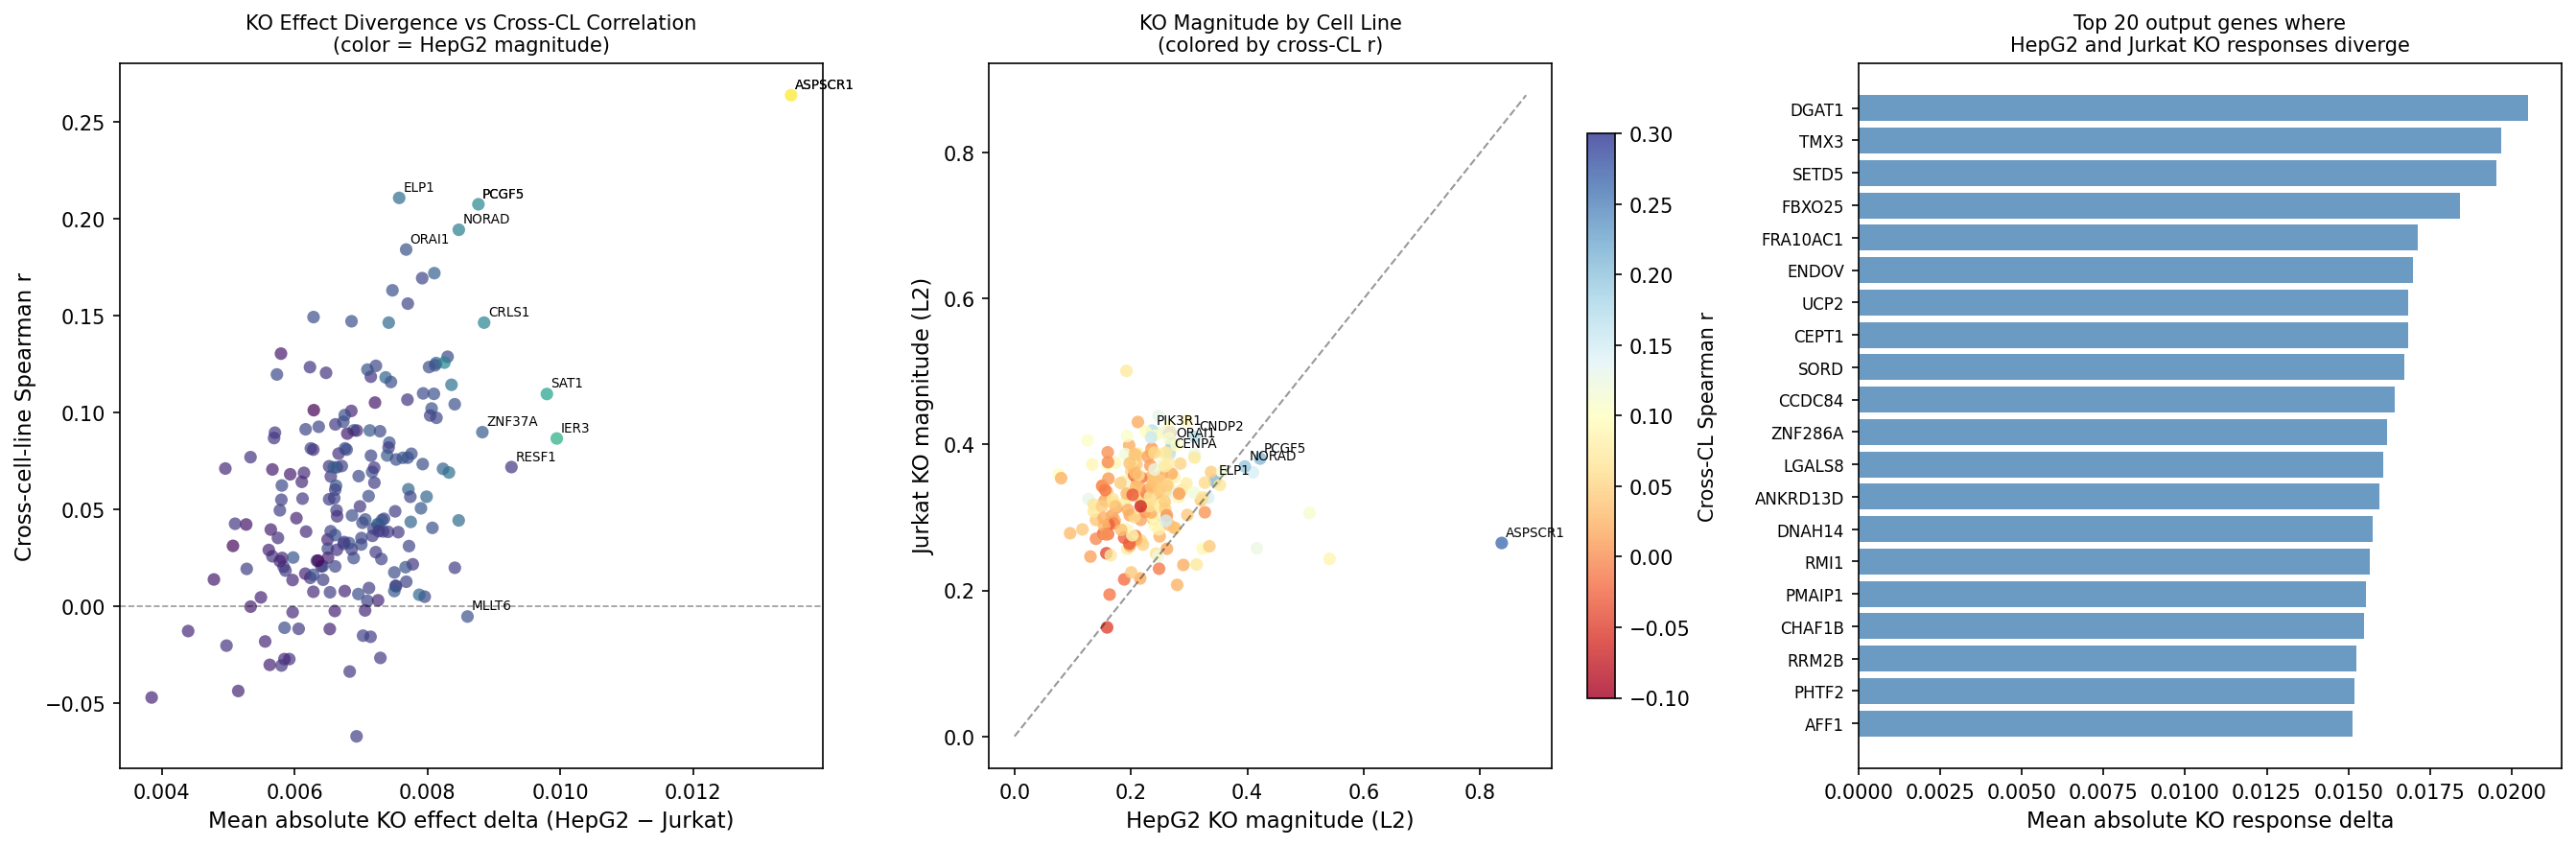

In [19]:

from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb04_ko_delta_analysis.png')


### Supplementary Interpretation — KO Effect Delta Analysis

**Genes with largest absolute KO response divergence:**
- **ASPSCR1** is both the highest HepG2-magnitude KO gene AND shows the largest cell-line
  divergence (delta=0.013, mag_h=0.84 vs mag_j=0.26). It is also the highest cross-r gene
  (r=0.26) — meaning it diverges greatly *in magnitude* but the direction of its effect is
  relatively consistent. This is a HepG2-dominant transcriptional regulator.
- **IER3** (immediate early response gene 3) and **SAT1** (spermidine acetyltransferase) have
  large HepG2 KO effects with modest Jurkat counterparts — HepG2-specific regulatory hubs.
- **RESF1** shows the reverse pattern: larger Jurkat effect (0.50) than HepG2 (0.19) — a
  Jurkat-dominant input gene.

**Cosine-distance (most directionally divergent KO responses):**
- CTBP1-DT (transcriptional corepressor), ELL (Pol II elongation factor), KATNAL1 (microtubule
  severing) — these genes produce genuinely *opposite* KO responses in the two cell lines
  (cosine distance > 1.0 means >90° angle = anti-correlated directions). These represent the
  most extreme cell-line-specific regulatory routing.

**Top output genes showing most KO-response divergence:**
- **DGAT1** (diacylglycerol acyltransferase, lipid synthesis), **TMX3** (thioredoxin,
  ER oxidoreductase), **CEPT1** (cholinephosphotransferase) — **all lipid/ER metabolism genes**.
- This is striking: the output genes where HepG2 and Jurkat model predictions diverge most
  strongly are concentrated in **lipid metabolism and ER function** — consistent with HepG2's
  hepatocyte identity (lipid-heavy) vs Jurkat's T-cell identity (immune-focused).
- **UCP2** (mitochondrial uncoupling) and **SORD** (sorbitol dehydrogenase, liver enzyme) also
  appear — both are liver-enriched, supporting cell-line-specific metabolic routing.


## Overall Summary — NB04 In-Silico KO Analysis

### Key Findings

#### 1. Cross-Cell-Line Consistency: Globally Low (Analysis 4b — KEY result)
The headline result: **mean Spearman r = 0.057** across all 200 KO genes. The entire
distribution sits in [−0.07, +0.26]. No gene passes the r > 0.4 backbone threshold.
**This means that for every KO'd input gene, the model's response prediction is substantially
different between HepG2 and Jurkat models.**

This directly parallels the NB08 zeroshot/fewshot finding where TRAPPC3 had r=0.001 and
even MYC only reached r=0.355. In-silico KO confirms the same picture at the input level:
the ST models have learned profoundly cell-line-specific input-output routing, not a
shared backbone GRN that is cell-line-decorated.

#### 2. KO Effect Magnitudes: HepG2 Has Outlier Regulators (4a)
HepG2 has a subset of genes with very large KO effects (ASPSCR1 L2=0.84, IER3=0.54, SAT1=0.51)
that dwarf their Jurkat counterparts. These appear to be HepG2-specific regulatory hubs.
Jurkat shows a tighter distribution with fewer outliers (max=0.50).

#### 3. Pathway Coherence: Absent in HepG2, Marginal in Jurkat (4c)
The 200 KO genes lack ribosomal/proteasome/splicing representation. Of the groups tested:
- **ZNF transcription factors (N=10):** no coherence in HepG2 (p=0.62), marginal in Jurkat
  (p=0.038, z=1.71). The Jurkat model has slightly more coordinated ZNF-based regulation.
- **Chromatin regulators (N=3):** not significant in either cell line.
No pathway group shows strong within-pathway KO response coherence.

#### 4. UMAP: No Pathway Clustering (4d)
KO response profiles scatter diffusely in 2D. ZNF genes show mild local clustering in Jurkat.
Cross-r values are not spatially organized — backbone-consistency is not predicted by
gene location in KO-response space.

#### 5. Cell-Line-Divergent Output Genes: Lipid/ER Metabolism (Supplementary)
The output genes showing the largest KO response divergence between cell lines are enriched
in lipid metabolism and ER function (DGAT1, CEPT1, TMX3, UCP2, SORD).
This is biologically coherent: HepG2 hepatocytes are lipid-metabolizing cells, so the
HepG2 fine-tune has rerouted diverse input signals through lipid/ER output pathways.

---

### Connection to NB08 Zeroshot/Fewshot Findings

| Analysis | Method | Result |
|---|---|---|
| NB08 — MYC KD | Zeroshot Pearson r | r = 0.355 (moderate backbone) |
| NB08 — TRAPPC3 KD | Zeroshot Pearson r | r = 0.001 (fine-tune artifact) |
| NB04 — all 200 genes | In-silico KO Spearman r | mean r = 0.057 (near-zero universally) |
| NB04 — best gene (ASPSCR1) | In-silico KO Spearman r | r = 0.26 (still below backbone threshold) |

**Convergent conclusion:** The ST perturbation models do not encode a shared backbone GRN that
is cell-line-decorated. Instead, the fewshot fine-tuning has created cell-line-specific
predictions throughout the input→output routing, not just in the output responses. Even when
the same input gene is zeroed out, the predicted consequences are cell-line-specific.

**The most biologically meaningful finding** is that the cell-line divergence in KO responses
is not random noise — it concentrates in lipid/ER metabolic output genes that are genuinely
differentially important in hepatocytes vs T-cells. This suggests the fine-tune has learned
*real biology* specific to each cell line, but this learning makes the models non-comparable
across cell lines without a cross-cell-line reference.
